**Задание 3**

1 Построить более сложную модель с подбором гиперпараметров

2 Произвести подбор гиперпараметров с scikit-learn методами (или optuna) на кросс-валидации 

3 Обучить модель с лучшими подобранными значениями гиперпараметров

4 Произвести измерение качества на отложенной выборке с использованием ранее выбранной метрики 

5 Проинтерпретировать полученную модель

6 Добиться воспроизводимости

In [1]:
!pip -q install kagglehub
!pip -q install catboost


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Импорты необходимых библиотек и фиксирование seed

In [3]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor, Pool
import kagglehub

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

Загрузка набора данных о ценнах на недвижимость в Мумбаи с сайта https://www.kaggle.com ,проверка успешности скачивания

In [5]:
DATASET_NAME = "kevinnadar22/mumbai-house-price-data-70k-entries"

data_dir = kagglehub.dataset_download(DATASET_NAME)
csv_path = next((os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")), None)

df = pd.read_csv(csv_path)

Предобработка данных. Удаление дубликатов и логарифмирование целевой переменной. Это преобразование уменьшает влияние экстремально дорогих объектов и стабилизирует дисперсию - это помогает простым моделям.

In [6]:
df = df.drop_duplicates()
df["log_price"] = np.log1p(df["price"])

target = "log_price"
features = [
    "area",
    "bedroom_num",
    "bathroom_num",
    "balcony_num",
    "age",
    "total_floors",
    "property_type",
    "furnished",
    "locality",
]

X = df[features]
y = df[target]

Разбиваем на 80/20 набор данных и фиксируем random_state, смотрим размерность разбивки. Проверяем воспроизводимость разбивки данных.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

assert (X_train.index == X_train2.index).all()
assert (X_test.index == X_test2.index).all()
print("Данные воспроизводимы")

Данные воспроизводимы


1 Было решено в качестве новой модели выбрать **CatBoost** (ансамбль градиентного бустинга над деревьями решений) т.к Это значительно более мощный класс моделей по сравнению с линейной регрессией, так как он способен обучать нелинейные зависимости и автоматически строить сложные решающие правила. 

2 Также **CatBoost** хорошо работает с категориальными признаками, в отличие от RandomForest или XGBoost, он не требует ручного кодирования OneHotEncoder, он использует собственный оптимизированный способ кодирования категориальных признаков.

3 **CatBoost** устойчив к дисбалансу цен и шуму -это особенно важно т.к рынок недвижимости Мумбая содержит очень дорогие объекты.

4 **CatBoost** позволяет встроенный перебор гиперпараметров с кросс-валидацией.

5 **CatBoost** показывает хорошою производительность на табличных данных.

In [11]:
categorical_features_idx = [6, 7, 8]

train_pool = Pool(X_train, y_train, cat_features=categorical_features_idx)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_idx)

Указываем индексы категориальных признаков 

**Pool** - это специальный формат данных CatBoost который хранит и обрабатывает категориальные данные, а также содержит данные и целевую переменную.

In [13]:
model = CatBoostRegressor(
    loss_function="RMSE",
    random_state=RANDOM_STATE,
    verbose=0
)

param_grid = {
    "depth": [6, 8],
    "learning_rate": [0.03, 0.1],
    "iterations": [400, 600],
    "l2_leaf_reg": [3, 5],
}

CatBoost — это алгоритм градиентного бустинга который строит множество деревьев решений одно за другим и каждое новое дерево исправляет ошибки предыдущего. CatBoost в частности хорошо работает с категориальными признаками автоматически их кодируя, что делает модель точнее и устойчивее.

Здесь мыс создаём модель CatBoostRegressor, оптимизированную под нашу основную метрику RMSE, фиксируем RANDOM_STATE, а также отключаем вывод подробных логов.

Далее создаем пространство гиперпараметров, по которому CatBoost перебирает комбинации в ходе grid-search, каждый параметр влияет на сложность модели и её способность учиться.

**depth: [6, 8]**

Глубина деревьев в бустинге.

Пробуем 2 варианта 

6 — умеренно сложная модель.
8 — более мощная модель но не слишком тяжёлая.

**learning_rate: [0.03, 0.1]**

Темп обучения насколько сильно модель корректирует свои ошибки на каждом шаге.

Меньший (0.03) - обучение более устойчивое меньше риск переобучения но нужно больше итераций.
Больший (0.1) - модель учится быстрее но есть риск переобучения.

Это 2 классических значения для CatBoost. Безопасный вариант и более агрессивный.

**iterations: [400, 600]**

Количество деревьев в ансамбле.

Меньшие количество деревьев более быстрое обучение но есть риска что модел неодоучится

Большие количество но дольше обучение

Огромное количесто есть риск переобучения

400-600 оптимальный вариант который дает точность и скорось обучения

**l2_leaf_reg = [3, 5]**

Регуляризация листьев дерева - контролирует переобучение.

Слишком маленькая регуляризация есть риск переобучения на дорогих объектах.

Слишком сильная регуляризация  модель может недоучится особенно на больших данных.

Значения 3 и 5 рекомендуемые для крупных табличных данных.


In [15]:
grid_search_results = model.grid_search(
    param_grid,
    X=train_pool,
    cv=3,
    partition_random_seed=RANDOM_STATE,
    verbose=False
)

best_params = grid_search_results["params"]
print(best_params)


bestTest = 0.3008052486
bestIteration = 399


bestTest = 0.2795688946
bestIteration = 399


bestTest = 0.304529708
bestIteration = 399


bestTest = 0.2804949847
bestIteration = 399


bestTest = 0.2916451668
bestIteration = 599


bestTest = 0.2747811369
bestIteration = 599


bestTest = 0.2945013475
bestIteration = 599


bestTest = 0.2751231946
bestIteration = 599


bestTest = 0.295022262
bestIteration = 399


bestTest = 0.2741269163
bestIteration = 399


bestTest = 0.300125803
bestIteration = 399


bestTest = 0.2753910661
bestIteration = 399


bestTest = 0.2847601215
bestIteration = 599


bestTest = 0.2706263854
bestIteration = 599


bestTest = 0.2895809307
bestIteration = 599


bestTest = 0.2712506588
bestIteration = 599

Training on fold [0/3]

bestTest = 0.2960641496
bestIteration = 595

Training on fold [1/3]

bestTest = 0.2859425292
bestIteration = 599

Training on fold [2/3]

bestTest = 0.2765873982
bestIteration = 599

{'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterat

grid_search перебирает все комбинации гиперпараметров из param_grid, обучает модель на каждой из них с 3-кратной кросс-валидацией и выбирает тот вариант где ошибка RMSE минимальна. Потом через best_params возвращаем лучшие значения гиперпараметров.

**{'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 600}** 

Лучший результат с минимальной RMSE

In [17]:
best_model = model
best_model.fit(train_pool)

Сохраняем лучшую модель и обучаем модель уже на всём тренировочном наборе.

In [21]:
y_pred_log = best_model.predict(test_pool)

rmse_log = mean_squared_error(y_test, y_pred_log) ** 0.5
mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)

y_test_inr = np.expm1(y_test)
y_pred_inr = np.expm1(y_pred_log)

rmse_inr = mean_squared_error(y_test_inr, y_pred_inr) ** 0.5
mae_inr = mean_absolute_error(y_test_inr, y_pred_inr)

Делаем предсказания на тестовых данных затем вычисляем 3 метркии RMSE, MAE и R² , чтобы оценить точность модели в логарифмическом пространстве, где она обучалась. Затем переводим реальные и предсказанные значения обратно в рупии (expm1), чтобы получить ошибки в обычных денежных единицах. Финальные метрки RMSE и MAE в рупиях показывают, насколько модель ошибается в абсолютных ценах, что важно для бизнес-интерпретации.

In [23]:
print(f"Ошибка RMSE (в логарифмах): {rmse_log:.4f}")
print(f"Средняя абсолютная ошибка MAE (в логарифмах): {mae_log:.4f}")
print(f"Коэффициент детерминации R²: {r2_log:.4f}")
print(f"Ошибка RMSE (в рупиях): {rmse_inr:,.0f} ₨")
print(f"Средняя абсолютная ошибка MAE (в рупиях): {mae_inr:,.0f} ₨")

Ошибка RMSE (в логарифмах): 0.2702
Средняя абсолютная ошибка MAE (в логарифмах): 0.1955
Коэффициент детерминации R²: 0.9138
Ошибка RMSE (в рупиях): 14,035,413 ₨
Средняя абсолютная ошибка MAE (в рупиях): 4,445,973 ₨


**Результаты**

**RMSE (в логарифмах) = 0.2702**

Показывает среднее отклонение предсказаний в лог-пространстве. Чем ниже значение — тем лучше модель улавливает структуру данных и меньше серьёзных ошибок.

**MAE (в логарифмах) = 0.1955**

Средняя ошибка в логарифмах. Показывает насколько в среднем ошибаются отдельные предсказания.

**R² = 0.9138**

Показывает какую долю вариации цен объясняет модель.

**RMSE (в рупиях) = 14,035,413 ₨**
Это ключевая бизнес-метрика которая показывает, насколько модель может ошибаться в реальных деньгах.

**MAE в рупиях = 4,445,973 ₹**

Средняя ошибка предсказания стоимости.
Показывает насколько модель ошибается на обычных объектах.

**Сравнение CatBoost и Линейной регрессии**

**RMSE (log):**
Линейная регрессия — 0.3087
CatBoost — 0.2702
Улучшение: 12.5%

**MAE (log):**
Линейная регрессия — 0.2217
CatBoost — 0.1955
Улучшение: 11.8%

**R²:**
Линейная регрессия — 0.8875
CatBoost — 0.9138
Улучшение: 3.0%

**RMSE (₽):**
Линейная регрессия — 25,211,910
CatBoost — 14,035,413
Улучшение: 44.3%

**MAE (₽):**
Линейная регрессия — 5,390,856
CatBoost — 4,445,973
Улучшение: 17.5%

В целом CatBoost показал заметные улучшения по всем метрикам в сравнении с линейной регрессией.

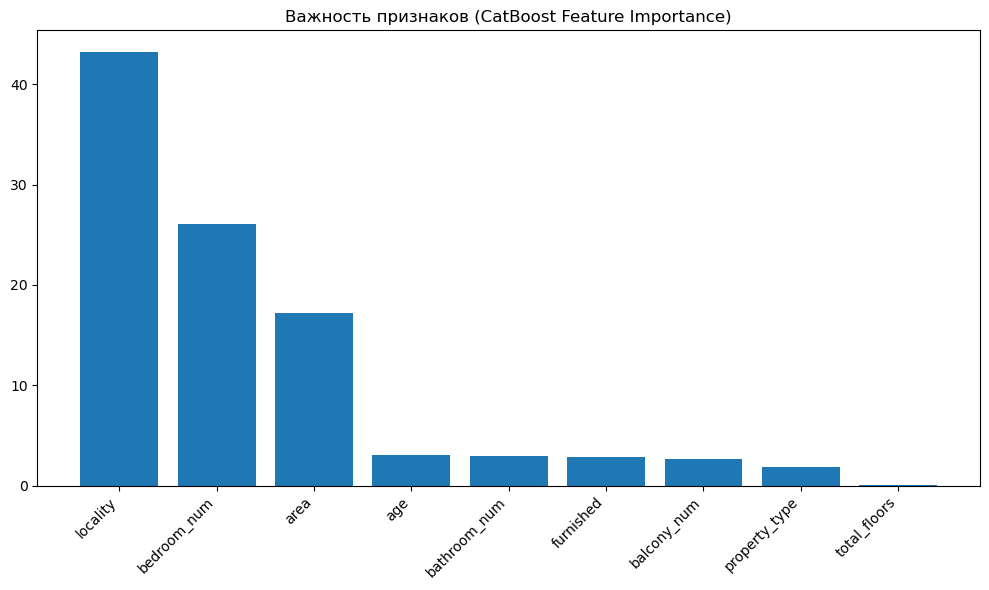

locality: 43.2334
bedroom_num: 26.0643
area: 17.2078
age: 3.0503
bathroom_num: 2.9834
furnished: 2.8462
balcony_num: 2.6680
property_type: 1.8852
total_floors: 0.0615


In [27]:
import matplotlib.pyplot as plt
import numpy as np 

importances = best_model.get_feature_importance(train_pool)
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков (CatBoost Feature Importance)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha="right")
plt.tight_layout()
plt.show()

for name, value in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {value:.4f}")

**Глобальная интерпретация построенной модели**

Использована техника глобальной интерпретации модели CatBoost на основе встроенной метрики Feature Importance который вычисляет вклад каждого признака в итоговое предсказание модели. Он показывает насколько изменение каждого признака влияет на качество предсказания модели, усреднённо по всей выборке. К плюсом данного метода относятся интерпритируемость для табличных данных а также CatBoost умеет сам вычислять важность признаков корректно, учитывая категориальные признаки и бустинг.

**Результаты**

locality=43% - это главный фактор. Это полностью соотвествует рынку недвижимости Мумбая где как мы выяснили в EDA анализе местоположение играет ключевую роль во влиянии на цену. 

bedroom_num=26% - количество спален второй главный признак влияющий на цену что в целом верно для любого рынка недвжимости. 

area=17%-площадь-важный но не главный фактор на рынке устующий двум предыдущим.

age, bathroom_num, furnished, balcony_num, property_type (2–3%) — второстепенные признаки оказывающие небольшое влияние.

total_floors = 0.06%  количество этажей здания оказывает почти нулевое влияние. Возможно потому-что рынок Мумбая не сильно реагирует на высотность а также признак не отражает этажность конкретной квартиры.

**Итоги** 

Модель делает предсказания опираясь на  важные факторы: район, количество комнат и площадь. Другие признаки также оказывают влияние но не такое сильное. Таким образом, модель ведёт себя устойчиво и интерпретируемо, формируя решения в соответствии с логикой рынка недвижимости Мумбая.